Данные - https://www.kaggle.com/usdot/flight-delays
Описание - Сводная информация о количестве своевременных, задержанных, отмененных и измененных рейсов в США за 2015 год (5.8 млн записей)
### Задачи:
1. Найти аэропорт с минимальной задержкой вылета
2. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport
3. Аэропорт с самой большой долей руления на 1 самолетовылет
4. Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика),  в зависимости от аэропорта вылета  


In [1]:
%time
import pandas as pd
import datetime
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.linear_model import LinearRegression

Wall time: 0 ns


In [3]:
airports = pd.read_csv('airports.csv')
airlines = pd.read_csv('airlines.csv')
flights = pd.read_csv('flights.csv', dtype={'ORIGIN_AIRPORT': str, 'DESTINATION_AIRPORT': str})

### Предобработка

In [4]:
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [4]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [5]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [7]:
print(airlines.shape)
print(airports.shape)
print(flights.shape)

(14, 2)
(322, 7)
(5819079, 31)


In [7]:
flights = pd.merge(flights, airports, left_on = 'ORIGIN_AIRPORT', right_on = 'IATA_CODE')
flights = pd.merge(flights, airlines, left_on = 'AIRLINE', right_on = 'IATA_CODE')
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,WEATHER_DELAY,IATA_CODE_x,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,IATA_CODE_y,AIRLINE_y
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
2,2015,1,1,4,AS,122,N413AS,ANC,PDX,50,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
3,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.


In [9]:
flights.shape

(5332914, 40)

In [10]:
 flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5332914 entries, 0 to 5332913
Data columns (total 40 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE_x            object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [11]:
flights.duplicated().sum()

0

In [12]:
flights.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE_x                    0
FLIGHT_NUMBER                0
TAIL_NUMBER              14367
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           83814
DEPARTURE_DELAY          83814
TAXI_OUT                 86612
WHEELS_OFF               86612
SCHEDULED_TIME               6
ELAPSED_TIME            101784
AIR_TIME                101784
DISTANCE                     0
WHEELS_ON                89942
TAXI_IN                  89942
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             89942
ARRIVAL_DELAY           101784
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5245484
AIR_SYSTEM_DELAY       4329554
SECURITY_DELAY         4329554
AIRLINE_DELAY          4329554
LATE_AIRCRAFT_DELAY    4329554
WEATHER_DELAY          4329554
IATA_CODE_x                  0
AIRPORT 

In [13]:
flights.CANCELLED.value_counts(normalize=True)

0    0.983606
1    0.016394
Name: CANCELLED, dtype: float64

In [14]:
flights.DIVERTED.value_counts(normalize=True)

0    0.997308
1    0.002692
Name: DIVERTED, dtype: float64

In [15]:
# Оставляем только рейсы, которые не были перенесены или отменены
flights = flights[(flights['DIVERTED'] == 0) & (flights['CANCELLED'] == 0)]
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,WEATHER_DELAY,IATA_CODE_x,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,IATA_CODE_y,AIRLINE_y
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
2,2015,1,1,4,AS,122,N413AS,ANC,PDX,50,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
5,2015,1,1,4,AS,144,N514AS,ANC,PDX,200,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.


In [16]:
flights.shape

(5231130, 40)

### 1. Найти аэропорт с минимальной задержкой вылета

In [38]:
# Учитываем вылеты, по которым задержка больше 0
flights_1 = flights[flights.DEPARTURE_DELAY > 0]
flights_1.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,WEATHER_DELAY,IATA_CODE_x,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,IATA_CODE_y,AIRLINE_y
16,2015,1,1,4,AS,43,N762AS,ANC,BET,1110,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
34,2015,1,2,5,AS,122,N471AS,ANC,PDX,50,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
38,2015,1,2,5,AS,144,N442AS,ANC,PDX,230,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
53,2015,1,2,5,AS,120,N442AS,ANC,SEA,1340,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
54,2015,1,2,5,AS,92,N584AS,ANC,SEA,1430,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.


In [18]:
flights_1.shape

(1970397, 40)

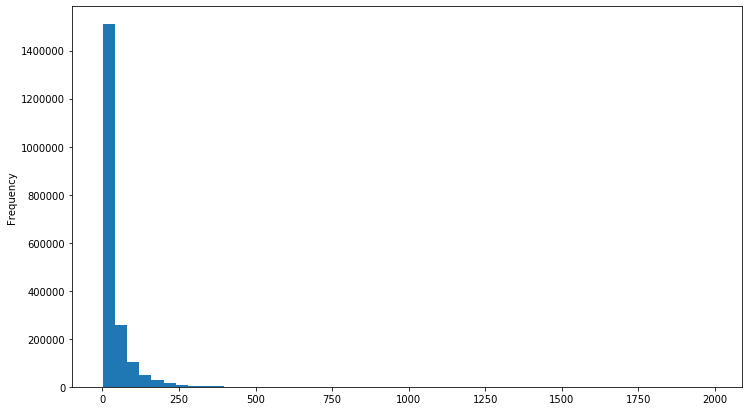

In [80]:
flights_1.DEPARTURE_DELAY.plot(kind='hist', figsize=(12, 7), bins=50)

In [39]:
print(flights_1.DEPARTURE_DELAY.median())
print(flights_1.DEPARTURE_DELAY.mean())

15.0
33.10903875555663


In [21]:
flights_1.DEPARTURE_DELAY.describe()

count    1.970397e+06
mean     3.296583e+01
std      5.316771e+01
min      1.000000e+00
25%      5.000000e+00
50%      1.500000e+01
75%      3.800000e+01
max      1.988000e+03
Name: DEPARTURE_DELAY, dtype: float64

In [22]:
flights_1.DEPARTURE_DELAY.value_counts().sort_index()

1.0       145677
2.0       110975
3.0        95419
4.0        85117
5.0        77714
           ...  
1631.0         1
1649.0         1
1670.0         1
1878.0         1
1988.0         1
Name: DEPARTURE_DELAY, Length: 1138, dtype: int64

In [40]:
groups = flights_1.groupby(['IATA_CODE_x'])
groups

In [24]:
groups.ngroups

322

In [41]:
result_task1_mean = groups.DEPARTURE_DELAY.mean().sort_values()
result_task1_mean

IATA_CODE_x
AKN     13.800000
ITO     16.411424
DLG     20.960000
HNL     22.167616
OGG     22.508665
          ...    
BJI     78.708861
INL     83.462500
PLN     89.295652
ESC     89.957746
VEL    133.600000
Name: DEPARTURE_DELAY, Length: 322, dtype: float64

In [42]:
result_task1_median = groups.DEPARTURE_DELAY.median().sort_values()
print ('Аэропорты с минимальной задержкой вылета: ', result_task1_median.head(5))

Аэропорты с минимальной задержкой вылета:  IATA_CODE_x
ITO    7.0
BLI    7.0
LWS    8.0
WYS    8.0
HNL    8.0
Name: DEPARTURE_DELAY, dtype: float64


### 2. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

In [28]:
airports[airports.AIRPORT=='Los Angeles International Airport']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
176,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807


In [43]:
flights_2 = flights[flights.DESTINATION_AIRPORT == 'LAX']
flights_2.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,WEATHER_DELAY,IATA_CODE_x,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,IATA_CODE_y,AIRLINE_y
31,2015,1,1,4,AS,150,N528AS,ANC,LAX,2340,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
69,2015,1,2,5,AS,150,N442AS,ANC,LAX,2340,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
103,2015,1,3,6,AS,150,N596AS,ANC,LAX,2340,...,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
138,2015,1,4,7,AS,150,N553AS,ANC,LAX,2340,...,0.0,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.
274,2015,1,8,4,AS,150,N557AS,ANC,LAX,2340,...,0.0,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,AS,Alaska Airlines Inc.


In [30]:
flights_2.shape

(192136, 40)

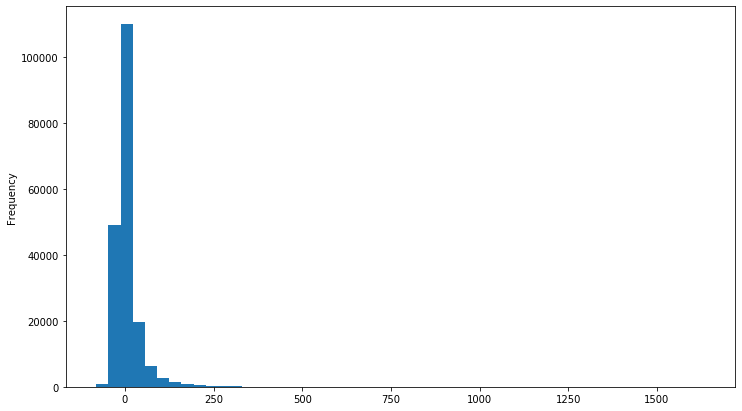

In [31]:
flights_2.ARRIVAL_DELAY.plot(kind='hist', figsize=(12, 7), bins=50)

In [35]:
print(flights_2.ARRIVAL_DELAY.median())
print(flights_2.ARRIVAL_DELAY.mean())

-3.0
6.109568222509056


In [33]:
flights_2.ARRIVAL_DELAY.describe()

count    192136.000000
mean          6.109568
std          41.541669
min         -81.000000
25%         -13.000000
50%          -3.000000
75%          12.000000
max        1636.000000
Name: ARRIVAL_DELAY, dtype: float64

In [44]:
groups2 = flights_2.groupby(['AIRLINE_x'])
groups2

In [85]:
groups2.ngroups

13

In [88]:
result_task2_mean = groups2.ARRIVAL_DELAY.mean().sort_values()
result_task2_mean.head(10)

AIRLINE_x
HA   -4.668819
B6    0.155539
AS    0.536180
DL    2.135468
AA    2.691133
US    3.039387
VX    4.424613
UA    8.551574
OO    8.645215
WN    9.008806
Name: ARRIVAL_DELAY, dtype: float64

In [87]:
result_task2_median = groups2.ARRIVAL_DELAY.median().sort_values()
print ('Cамые пунктуальные авиакомпании на прилет в Los Angeles International Airport: ', result_task2_median.head(10))

Cамые пунктуальные авиакомпании на прилет в Los Angeles International Airport:  AIRLINE_x
HA   -8.0
AA   -7.0
B6   -7.0
DL   -6.0
AS   -5.0
MQ   -4.0
US   -4.0
VX   -3.0
UA   -2.0
OO   -1.0
Name: ARRIVAL_DELAY, dtype: float64


### 3. Аэропорт с самой большой долей руления на 1 самолетовылет

In [51]:
groups3 = flights.groupby(['IATA_CODE_x'])
groups3

In [52]:
groups3.ngroups

322

In [54]:
f_count = groups3.size()
f_count

IATA_CODE_x
ABE     2274
ABI     2329
ABQ    19192
ABR      671
ABY      876
       ...  
WRG      664
WYS      208
XNA     9283
YAK      662
YUM     1877
Length: 322, dtype: int64

In [69]:
result_task3_mean = groups.TAXI_OUT.mean()
result_task3_mean

IATA_CODE_x
ABE    14.451560
ABI     9.818018
ABQ    11.706354
ABR    19.200000
ABY    12.887255
         ...    
WRG     7.030928
WYS    12.707317
XNA    15.247029
YAK     7.765625
YUM    12.560472
Name: TAXI_OUT, Length: 322, dtype: float64

In [76]:
fraction_mean = result_task3_mean / f_count
print ('Аэропорт с самой большой долей руления на 1 самолетовылет', fraction_mean.sort_values(ascending = False).head())

Аэропорт с самой большой долей руления на 1 самолетовылет IATA_CODE_x
ITH    0.625668
STC    0.183735
HYA    0.137550
ILG    0.128113
GST    0.125253
dtype: float64


In [68]:
result_task3_median = groups.TAXI_OUT.median()
result_task3_median

IATA_CODE_x
ABE    12.0
ABI     8.0
ABQ    10.0
ABR    15.0
ABY    11.0
       ... 
WRG     5.0
WYS    12.0
XNA    13.0
YAK     6.0
YUM    11.0
Name: TAXI_OUT, Length: 322, dtype: float64

In [75]:
fraction_median = result_task3_median / f_count
print ('Аэропорт с самой большой долей руления на 1 самолетовылет', fraction_median.sort_values(ascending = False).head())

Аэропорт с самой большой долей руления на 1 самолетовылет IATA_CODE_x
ITH    0.647059
STC    0.144578
AKN    0.111111
ILG    0.110000
HYA    0.108434
dtype: float64
